In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch 
import torch.nn.functional as F
import json
import os

In [2]:
MODEL_NAME = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto")
model.eval()
print()

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
input_text = "Dubai is a"

In [4]:
input_ids = tokenizer(input_text, return_tensors="pt").to("cuda")

In [5]:
outputs = model(**input_ids)
logits = outputs.logits[:, -1, :].clone() 

In [21]:
import pandas as pd
dfs = pd.DataFrame()
temps = [0.1,1,20]
for temp  in temps:
    logits = outputs.logits[:, -1, :].clone()/temp
    top_k_logits, top_k_indices = torch.topk(logits, 20, dim=-1)
    top_k_probs = F.softmax(top_k_logits, dim=-1)[0].cpu().tolist()
    top_k_indices = top_k_indices[0].cpu().tolist()
    # break
    df = pd.DataFrame({ "indices":top_k_indices, "temperature":top_k_probs})
    df[temp] = df["temperature"]*100
    df["tokens"] = tokenizer.convert_ids_to_tokens(df["indices"])
    if dfs.empty:
        dfs = df.copy()
    else:
        dfs[temp] = df[temp]

dfs

,indices,temperature,0.1,tokens,1,20
0,3413,9.991962e-01,9.991962e+01,▁city,42.800924,5.890790
1,5228,8.033105e-04,8.033105e-02,▁global,20.988259,5.684597
2,141930,5.074513e-07,5.074513e-05,▁cosmopolitan,10.046794,5.479012
3,42536,8.058007e-09,8.058007e-07,▁vibrant,6.639124,5.366689
4,5354,1.235945e-10,1.235945e-08,▁modern,4.372079,5.255757
5,130898,1.226209e-10,1.226209e-08,▁bustling,4.368621,5.255549
6,101141,1.673108e-13,1.673108e-11,▁futuristic,2.258606,5.085022
7,141636,8.642570e-17,8.642570e-15,▁sprawling,1.059625,4.896193
8,36726,5.014315e-17,5.014315e-15,▁fascinating,1.003481,4.882883
9,2134,2.347134e-17,2.347134e-15,▁world,0.930127,4.864385


<Axes: xlabel='tokens'>

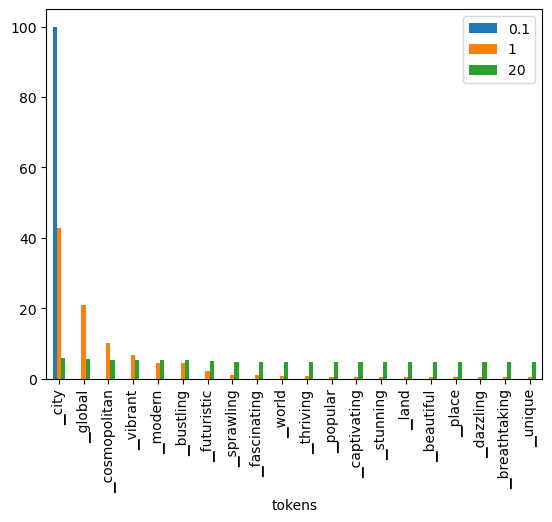

In [22]:
dfs.set_index('tokens')[temps].plot(kind='bar')

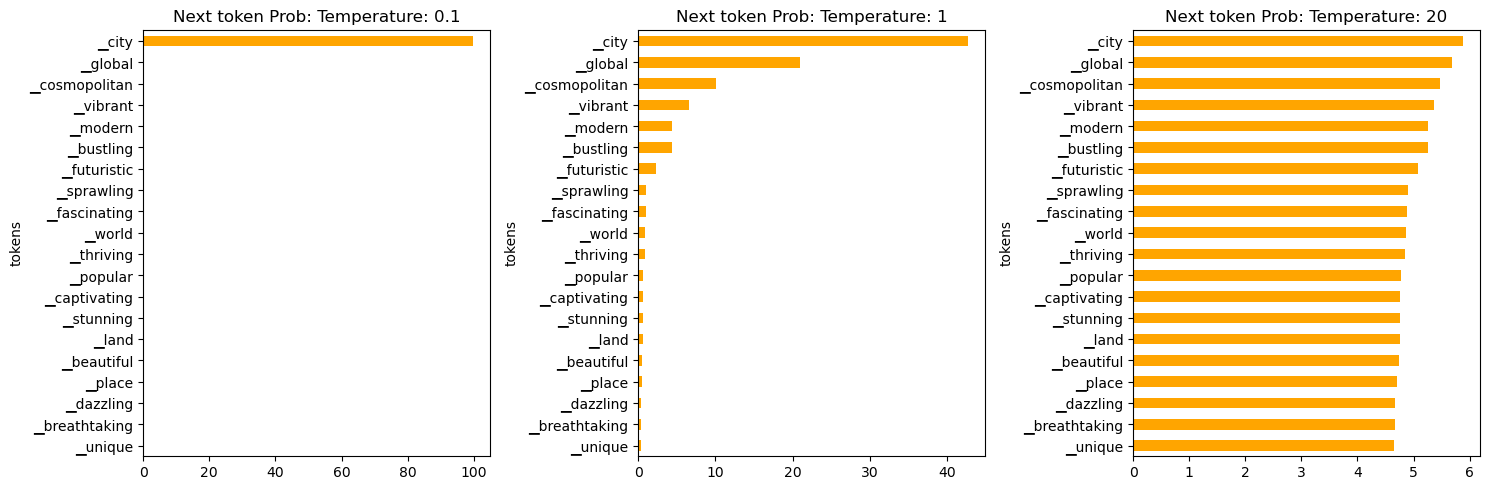

In [32]:
# Create subplots with 1 row and 3 columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for temp in temps:
    dfs.sort_values(temp).set_index('tokens')[temp].plot(kind='barh', ax=axes[temps.index(temp)], title=f"Next token Prob: Temperature: {temp}", color='orange')

# Display the plots
plt.tight_layout()
plt.show()

In [52]:
dfp = dfs.set_index('tokens')[[1]].rename(columns={1:'probability'})
top_p = 0.99
top_ps = [0.5,0.9,0.99]
dfp['cumprob'] = dfp['probability'].cumsum()
dfp["selected"] = 0
dfp.loc[dfp['cumprob']<top_p*100,"selected"] = 1
dfp

,probability,cumprob,selected
tokens,,,
▁city,42.800924,42.800924,1
▁global,20.988259,63.789183,1
▁cosmopolitan,10.046794,73.835977,1
▁vibrant,6.639124,80.475102,1
▁modern,4.372079,84.847181,1
▁bustling,4.368621,89.215802,1
▁futuristic,2.258606,91.474408,1
▁sprawling,1.059625,92.534033,1
▁fascinating,1.003481,93.537514,1


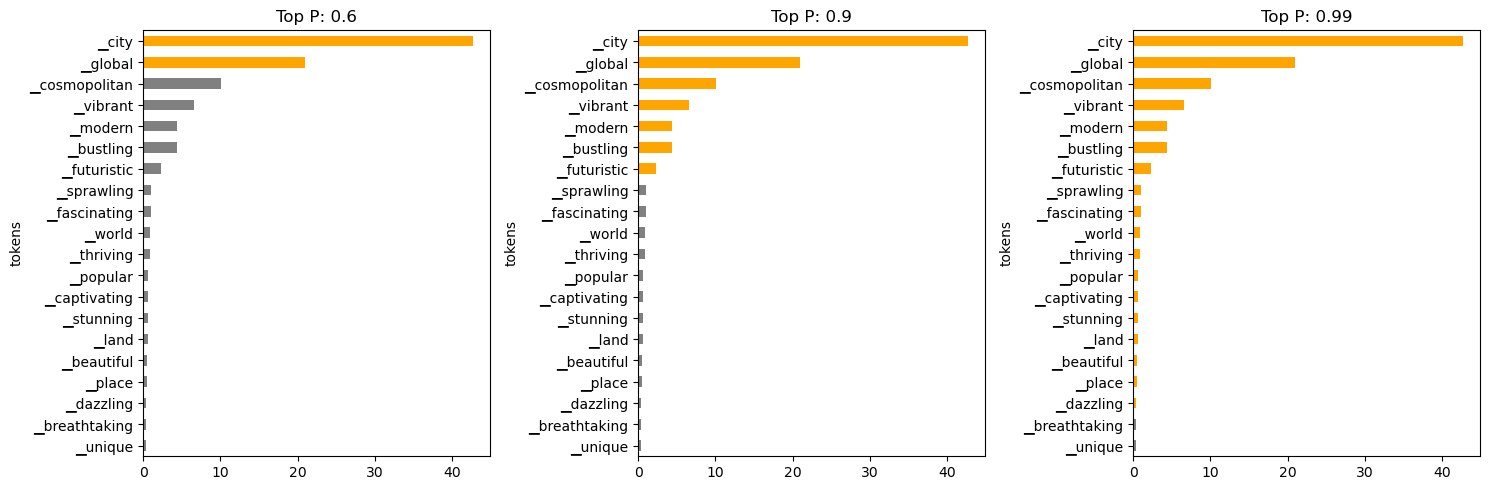

In [153]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
top_p=0.6
dfp['cumprob'] = dfp['probability'].cumsum()
dfp["selected"] = 1
dfp.loc[dfp['cumprob']<(1-top_p)*100,"selected"] = 0
color_mapping = {0: 'grey', 1: 'orange'}
dfp = dfp.sort_values('probability').reset_index(drop=True)
dfp.set_index('tokens')['probability'].plot(kind='barh',color=dfp["selected"].map(color_mapping),ax=axes[0], title=f"Top P: {top_p}")

top_p=0.9
dfp['cumprob'] = dfp['probability'].cumsum()
dfp["selected"] = 1
dfp.loc[dfp['cumprob']<(1-top_p)*100,"selected"] = 0
color_mapping = {0: 'grey', 1: 'orange'}
dfp = dfp.sort_values('probability').reset_index(drop=True)
dfp.set_index('tokens')['probability'].plot(kind='barh',color=dfp["selected"].map(color_mapping),ax=axes[1], title=f"Top P: {top_p}")

top_p=0.99
dfp['cumprob'] = dfp['probability'].cumsum()
dfp["selected"] = 1
dfp.loc[dfp['cumprob']<(1-top_p)*100,"selected"] = 0
color_mapping = {0: 'grey', 1: 'orange'}
dfp = dfp.sort_values('probability').reset_index(drop=True)
dfp.set_index('tokens')['probability'].plot(kind='barh',color=dfp["selected"].map(color_mapping),ax=axes[2], title=f"Top P: {top_p}")
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Top P: 0.9'}, ylabel='tokens'>

<Axes: title={'center': 'Top P: 0.9'}, ylabel='tokens'>

<Figure size 640x480 with 0 Axes>

In [109]:
dfp['selected']

tokens
▁unique          0
▁breathtaking    0
▁dazzling        1
▁place           1
▁beautiful       1
▁land            1
▁stunning        1
▁captivating     1
▁popular         1
▁thriving        1
▁world           1
▁fascinating     1
▁sprawling       1
▁futuristic      1
▁bustling        1
▁modern          1
▁vibrant         1
▁cosmopolitan    1
▁global          1
▁city            1
Name: selected, dtype: int64

<Axes: title={'center': 'Top P: 0.99'}, ylabel='tokens'>

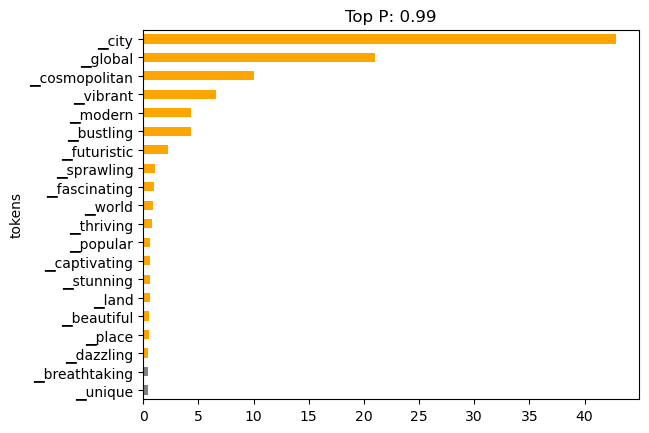

In [105]:
dfp['probability'].plot(kind='barh', title=f"Top P: {top_p}", color=dfp['selected'].map(color_mapping))